## LOAD DATA

In [0]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn import metrics
from sklearn import model_selection

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [170]:
# Load processed training and test data
!ls -al
!mkdir prognostic

from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/My\ Drive/MLProjects/Prognostic/data/*.csv /content/prognostic
! ls -al /content/prognostic

total 24
drwxr-xr-x 1 root root 4096 Aug 31 01:33 .
drwxr-xr-x 1 root root 4096 Aug 31 01:24 ..
drwxr-xr-x 1 root root 4096 Aug 28 16:06 .config
drwx------ 3 root root 4096 Aug 31 01:33 drive
drwxr-xr-x 2 root root 4096 Aug 31 01:35 prognostic
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data
mkdir: cannot create directory ‘prognostic’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 14868
drwxr-xr-x 2 root root     4096 Aug 31 01:35 .
drwxr-xr-x 1 root root     4096 Aug 31 01:33 ..
-rw------- 1 root root    73938 Aug 31 01:35 test.csv
-rw------- 1 root root    73938 Aug 31 08:42 test_processed.csv
-rw------- 1 root root 15059885 Aug 31 08:42 train_processed.csv


In [171]:
df_train=pd.read_csv('prognostic/train_processed.csv')
df_test=pd.read_csv('prognostic/test_processed.csv')

display(df_train.head(3))
display(df_test.head(3))

,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,setting1_av,setting2_av,s2_av,s3_av,s4_av,s7_av,s8_av,s9_av,s11_av,s12_av,s13_av,s14_av,s15_av,s17_av,s20_av,s21_av,setting1_std,setting2_std,s2_std,s3_std,s4_std,s7_std,s8_std,s9_std,s11_std,s12_std,s13_std,s14_std,s15_std,s17_std,s20_std,s21_std,rul,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,-0.000700,-0.000400,641.820000,1589.700000,1400.600000,554.360000,2388.06,9046.190000,47.47,521.66,2388.020,8138.620000,8.419500,392.000000,39.060000,23.4190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,0.000600,-0.000350,641.985000,1590.760000,1401.870000,554.055000,2388.05,9045.130000,47.48,521.97,2388.045,8135.055000,8.425650,392.000000,39.030000,23.4213,0.001838,0.000071,0.233345,1.499066,1.796051,0.431335,0.014142,1.499066,0.014142,0.438406,0.035355,5.041671,0.008697,0.000000,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,-0.001033,-0.000133,642.106667,1589.836667,1402.646667,554.123333,2388.06,9047.733333,47.41,522.12,2388.040,8134.446667,8.423033,391.333333,39.003333,23.3956,0.003113,0.000379,0.267644,1.918654,1.850009,0.327159,0.020000,4.632023,0.121655,0.404475,0.026458,3.717450,0.007640,1.154701,0.055076,0.044573,189,0,0


,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,setting1_av,setting2_av,s2_av,s3_av,s4_av,s7_av,s8_av,s9_av,s11_av,s12_av,s13_av,s14_av,s15_av,s17_av,s20_av,s21_av,setting1_std,setting2_std,s2_std,s3_std,s4_std,s7_std,s8_std,s9_std,s11_std,s12_std,s13_std,s14_std,s15_std,s17_std,s20_std,s21_std,rul,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552,-5.666667e-04,0.0003,642.44,1584.696667,1399.330000,554.223333,2388.083333,9049.986667,47.350000,521.986667,2388.076667,8132.676667,8.411533,392.000000,38.973333,23.374733,0.001950,0.000173,0.437150,3.094614,1.475534,0.172143,0.005774,5.594375,0.104403,0.349333,0.020817,2.372706,0.009411,1.00000,0.145717,0.028070,112,0,0
1,2,49,0.0018,-0.0001,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618,4.336809e-19,-0.0002,642.68,1587.293333,1408.673333,553.686667,2388.113333,9047.940000,47.536667,521.763333,2388.103333,8127.106667,8.439700,391.666667,38.893333,23.283367,0.002536,0.000173,0.153948,0.612563,4.747803,0.491664,0.061101,3.917742,0.119304,0.455448,0.011547,1.570234,0.015373,0.57735,0.090738,0.018825,98,0,0
2,3,126,-0.0016,0.0004,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740,-4.333333e-04,0.0003,643.06,1589.626667,1414.756667,552.663333,2388.160000,9048.406667,47.703333,520.610000,2388.170000,8131.030000,8.442600,394.666667,38.723333,23.245433,0.001607,0.000100,0.180000,0.931146,3.580703,0.405010,0.030000,0.752152,0.153080,0.416173,0.036056,2.819699,0.026739,0.57735,0.188768,0.025085,69,0,0


In [0]:
#Create Training and Test data label series and Create the list of Original Feature (-constant features) and List of Original+Added Feature (-constant features)
original_sensor_features = ['setting1', 'setting2', 'setting3', 's1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20', 's21']
constant_sensor_features = ['setting3','s1', 's5' , 's6', 's10', 's16', 's18', 's19']


variable_sensor_features = ['setting1', 'setting2', 's2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20', 's21']
variable_sensor_features_fx= ['setting1', 'setting2', 's2', 's3', 's4',
       's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20',
       's21', 's2_av', 's3_av', 's4_av', 's7_av', 's8_av', 's9_av', 's11_av',
       's12_av', 's13_av', 's14_av', 's15_av', 's17_av', 's20_av', 's21_av',
       's2_std', 's3_std', 's4_std', 's7_std', 's8_std', 's9_std', 's11_std',
       's12_std', 's13_std', 's14_std', 's15_std', 's17_std', 's20_std',
       's21_std']

X_train = df_train[variable_sensor_features]
X_train_fx = df_train[variable_sensor_features_fx]

X_test = df_test[variable_sensor_features]
X_test_fx = df_test[variable_sensor_features_fx]

y_train = df_train['label_bnc']
y_test = df_test['label_bnc']

In [173]:
##Binary Classification Label: label_bnc = if ttf is <= the parameter period then 1, else 0 (values = 0 and 1)
##i.e. 0 mean  Will Not Fail / Dont Require Maintenance
##and 1 means Will Fail / Require Maintenance 
print(y_train.value_counts())
print(y_test.value_counts())

0    17531
1     3100
Name: label_bnc, dtype: int64
0    75
1    25
Name: label_bnc, dtype: int64


TALK ABOUT imbalanced data and What Evaluation Metrics to use etc.....

    Binary Classification Label: label_bnc = if ttf is <= the parameter period then 1, else 0 (values = 0 and 1)
          bnc = 1 is POSITIVE PREDICTION -> predicting failure i.e., maintenance required
          bnc = 0 is NEGATIVE PREDICTION-> predicting NO FAILURE i.e., maintenance not required

## HELPER FUNCTIONS


In [0]:
def plot_confusion_matrix(y_true, y_pred,classes,normalize=False,title=None,cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting normalize = True
  """
  
  if not title:
    if normalize:
      title = "Normalzied Confusion Matrix"
    else:
      title = "Confusion Matrix, without Normalization"
      
  
  #Compute confusion matrix
  cm = metrics.confusion_matrix(y_true, y_pred)
  
  #Only use the labels that appear in the data
  classes = classes[unique_labels(y_true, y_pred)]
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='True label',
         xlabel='Predicted label')
  # Rotate the tick labels and set their alignment.
  
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")
  
  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")
    
  fig.tight_layout()
  return ax

In [0]:
##########################################################################################
def evaluate_classifier(model, clf, X_test, y_test):
  
  y_pred = clf.predict(X_test)
  
  if hasattr(clf, 'predict_proba'):
    y_score = clf.predict_proba(X_test)[:,1]
  elif hasattr(clf, 'decision_function'):
    y_score = clf.decision_function(X_test)
  else:
    y_score = y_pred
  
  
  binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Balanced Accuracy' : metrics.balanced_accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                      }
  
  df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
  df_metrics.columns = [model]
  
  return df_metrics
  
##########################################################################################

def grid_search_classifier(model, clf, X_train, X_test, y_train, y_test, params=None, score=None):
      
    """Perfor Grid Search hyper parameter tuning on a classifier.
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        X_train: the training set 
        X_test: the test set
        y_train: the training set labels
        y_test: the test set labels
        
        params (dict): Grid Search parameters
        score (str): Grid Search score
        
    Returns:
        Tuned Clssifier object
        dataframe of model predictions and scores
    
    """
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [0]:
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main binary classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dataframe: ROC thresholds
        dataframe: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
        plot: Precision-Recall threshold; also show the number of engines predicted for maintenace per period (queue).
        plot: TPR-FPR threshold
        
    """
      
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  


    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []  
    for thr in thresh_roc:  
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model

    

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc,1)

    engines_prc = []  
    for thr in thresh_prc:  
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])

        print('\nPrecision-Recall Thresholds:\n')
        print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])

    if plot_out:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR')  
        ax3.plot(thresh_roc, tpr, color='green',label='TPR') 
        ax3.plot(thresh_roc, engines_roc, color='blue',label='Engines') 
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.legend(loc='upper right', fontsize='small')

        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
        ax4.plot(thresh_prc, recall, color='green',label='Recall') 
        ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines') 
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('Threshold')  
        ax4.set_ylabel('%')
        ax4.legend(loc='lower left', fontsize='small')

    return  df_metrics, df_roc_thresh, df_prc_thresh

## BASELINE CLASSIFICATION MODEL AND EVALUATION METRICS

,Baseline Logistic Reg
Accuracy,0.880000
Balanced Accuracy,0.773333
Precision,0.933333
Recall,0.560000
F1 Score,0.700000
ROC AUC,0.976533


Confusion matrix, without normalization


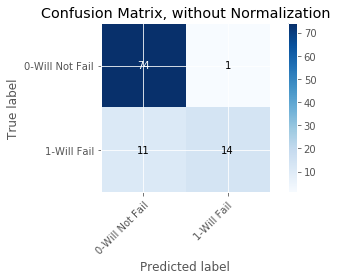

In [177]:
lr = LogisticRegression(random_state=2, solver='liblinear', max_iter=1000)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_eval = evaluate_classifier("Baseline Logistic Reg", lr, X_test, y_test)
display(lr_eval)
plot_confusion_matrix(y_test, y_pred, classes=np.array(['0-Will Not Fail', '1-Will Fail', ]),normalize=False,title=None,cmap=plt.cm.Blues)

We will now create a test harness using following classification algorithms and evaluate them using the helper functions which we have defined above

Logistic Regression
SVM
Linear SVC
Gaussian NB
KNN
Random Forest
Additional for each of these algorithms we will use two variants

_A -> means model with original features
_B -> means model with addtional engineered features included
For each of these models we will apply GridSearch using various parameters and we will evalute against the roc_auc score to select best set of parameters

## CLASSIFICATION MODEL HARNESS and EVALUATION METRICES

### Logistic Regressions

In [178]:
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


model_A = 'Logistic Regression A'
clf_lr_A = LogisticRegression(random_state=2, max_iter=1000)
model_B = 'Logistic Regression B'
clf_lr_B = LogisticRegression(random_state=2, max_iter=1000)

#grid_search_classifier(model, clf, X_train, X_test, y_train, y_test, params=None, score=None):

gs_clf_lr_A, pred_clf_lr_A = grid_search_classifier(model_A, clf_lr_A, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
gs_clf_lr_B, pred_clf_lr_B = grid_search_classifier(model_B, clf_lr_B, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score)

eval_lr_A = evaluate_classifier('Logistic Regression A', gs_clf_lr_A, X_test, y_test)
eval_lr_B = evaluate_classifier('Logistic Regression B', gs_clf_lr_B, X_test_fx, y_test)

metrics_lr = pd.concat([eval_lr_A, eval_lr_B], axis=1)
display(metrics_lr)



,Logistic Regression A,Logistic Regression B
Accuracy,0.910000,0.920000
Balanced Accuracy,0.820000,0.853333
Precision,1.000000,0.947368
Recall,0.640000,0.720000
F1 Score,0.780488,0.818182
ROC AUC,0.980267,0.979200


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

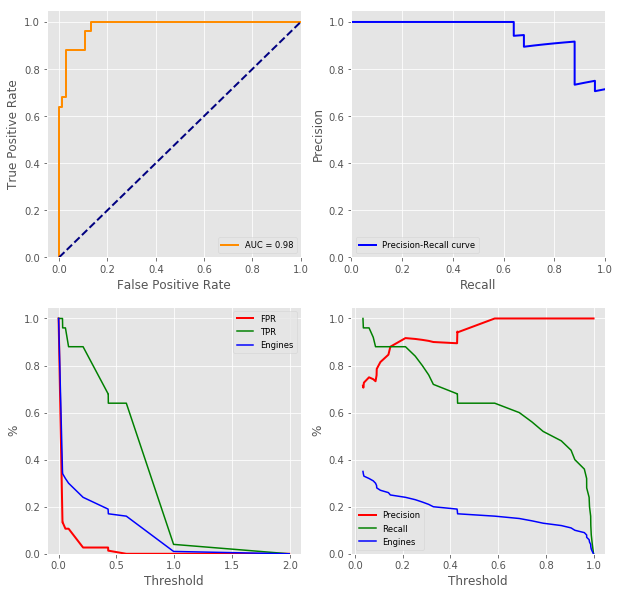

In [179]:
display(gs_clf_lr_A, gs_clf_lr_B)
metrics_clf_lr_A, roc_clf_lr_A, prc_clf_lr_A = bin_class_metrics(model_A, y_test, pred_clf_lr_A.y_pred, pred_clf_lr_A.y_score, print_out=False, plot_out=True)
metrics_clf_lr_B, roc_clf_lr_B, prc_clf_lr_B = bin_class_metrics(model_B, y_test, pred_clf_lr_B.y_pred, pred_clf_lr_B.y_score, print_out=False, plot_out=False)

### Linear SVC


In [180]:
gs_params = {'C': [.001, .01 ,.1 ]}
gs_score = 'roc_auc'

model_A = 'Linear SVC A'
clf_LSVC_A = LinearSVC(random_state=123, max_iter=1000)
model_B = 'Linear SVC B'
clf_LSVC_B = LinearSVC(random_state=123, max_iter=1000)


gs_clf_LSVC_A, pred_clf_LSVC_A = grid_search_classifier(model_A, clf_LSVC_A, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
gs_clf_LSVC_B, pred_clf_LSVC_B = grid_search_classifier(model_B, clf_LSVC_B, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score)

eval_LSVC_A = evaluate_classifier(model_A, gs_clf_LSVC_A, X_test, y_test)
eval_LSVC_B = evaluate_classifier(model_B, gs_clf_LSVC_B, X_test_fx, y_test)

metrics_LSVC = pd.concat([eval_LSVC_A, eval_LSVC_B], axis=1)
display(metrics_LSVC)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Linear SVC A,Linear SVC B
Accuracy,0.880000,0.940000
Balanced Accuracy,0.773333,0.933333
Precision,0.933333,0.851852
Recall,0.560000,0.920000
F1 Score,0.700000,0.884615
ROC AUC,0.972800,0.977600


LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
          verbose=0)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
          verbose=0)

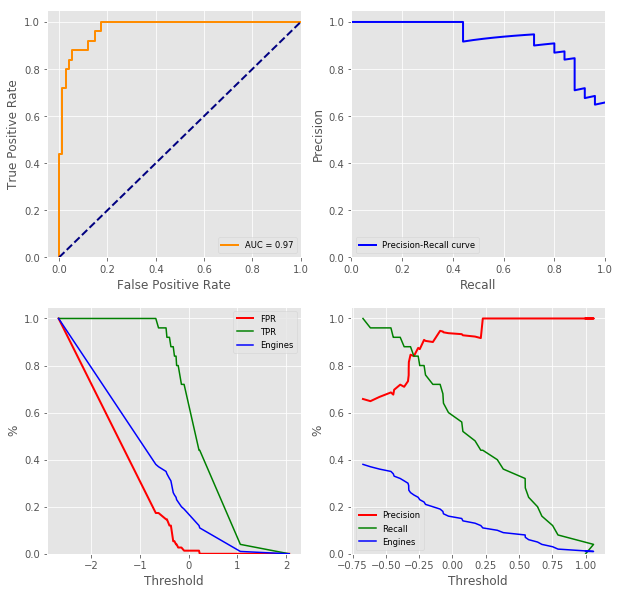

In [181]:
display(gs_clf_LSVC_A, gs_clf_LSVC_B)
metrics_clf_LSVC_A, roc_LSVC_A, prc_LSVC_A = bin_class_metrics(model_A, y_test, pred_clf_LSVC_A.y_pred, pred_clf_LSVC_A.y_score, print_out=False, plot_out=True)
metrics_clf_LSVC_B, roc_LSVC_B, prc_LSVC_B = bin_class_metrics(model_B, y_test, pred_clf_LSVC_B.y_pred, pred_clf_LSVC_B.y_score, print_out=False, plot_out=False)

### Gaussian Naive Bayes

In [182]:
gs_params = {}
gs_score = 'roc_auc'


model_A = 'Gaussian NB A'
clf_gnb_A = GaussianNB()
model_B = 'Gaussian NB B'
clf_gnb_B = GaussianNB()

gs_clf_gnb_A, pred_clf_gnb_A = grid_search_classifier(model_A, clf_gnb_A, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
gs_clf_gnb_B,  pred_clf_gnb_B = grid_search_classifier(model_B, clf_gnb_B, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score)

eval_gnb_A = evaluate_classifier(model_A, gs_clf_gnb_A, X_test, y_test)
eval_gnb_B = evaluate_classifier(model_B, gs_clf_gnb_B, X_test_fx, y_test)

metrics_gnb = pd.concat([eval_gnb_A, eval_gnb_B], axis=1)
display(metrics_gnb)

,Gaussian NB A,Gaussian NB B
Accuracy,0.940000,0.940000
Balanced Accuracy,0.933333,0.946667
Precision,0.851852,0.827586
Recall,0.920000,0.960000
F1 Score,0.884615,0.888889
ROC AUC,0.987733,0.982133


GaussianNB(priors=None, var_smoothing=1e-09)

GaussianNB(priors=None, var_smoothing=1e-09)

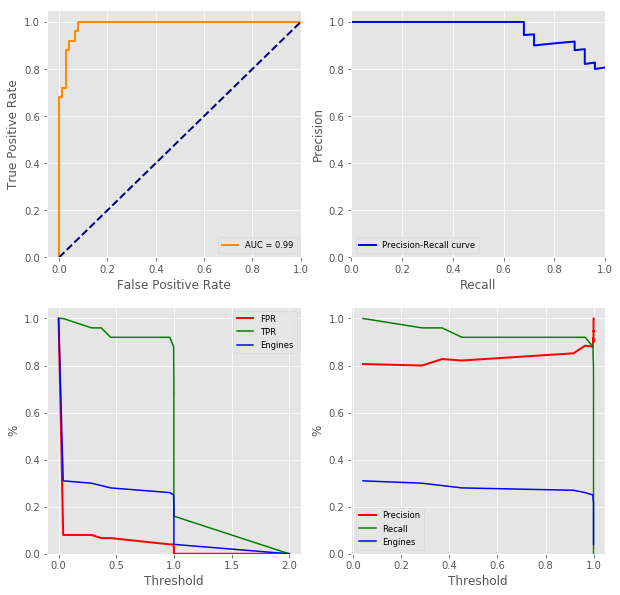

In [183]:
display(gs_clf_gnb_A, gs_clf_gnb_B)
metrics_clf_gnb_A, roc_gnb_A, prc_gnb_A = bin_class_metrics(model_A, y_test, pred_clf_gnb_A.y_pred, pred_clf_gnb_A.y_score, print_out=False, plot_out=True)
metrics_clf_gnb_B, roc_gnb_B, prc_gnb_B = bin_class_metrics(model_B, y_test, pred_clf_gnb_B.y_pred, pred_clf_gnb_B.y_score, print_out=False, plot_out=False)

### KNN

In [184]:
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'


model_A = 'KNN A'
clf_KNN_A = KNeighborsClassifier(n_jobs=-1)
model_B = 'KNN B'
clf_KNN_B = KNeighborsClassifier(n_jobs=-1)

gs_clf_KNN_A, pred_clf_KNN_A = grid_search_classifier(model_A, clf_KNN_A, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
gs_clf_KNN_B, pred_clf_KNN_B = grid_search_classifier(model_B, clf_KNN_B, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score)

eval_KNN_A = evaluate_classifier(model_A, gs_clf_KNN_A, X_test, y_test)
eval_KNN_B = evaluate_classifier(model_B, gs_clf_KNN_B, X_test_fx, y_test)

metrics_KNN = pd.concat([eval_KNN_A, eval_KNN_B], axis=1)
display(metrics_KNN)

,KNN A,KNN B
Accuracy,0.910000,0.920000
Balanced Accuracy,0.833333,0.853333
Precision,0.944444,0.947368
Recall,0.680000,0.720000
F1 Score,0.790698,0.818182
ROC AUC,0.935200,0.962400


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='uniform')

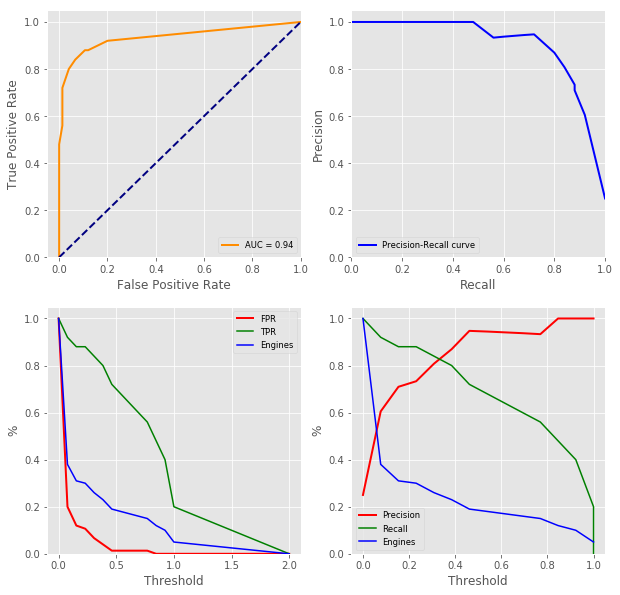

In [185]:
display(gs_clf_KNN_A, gs_clf_KNN_B)
metrics_clf_KNN_A, roc_KNN_A, prc_KNN_A = bin_class_metrics(model_A, y_test, pred_clf_KNN_A.y_pred, pred_clf_KNN_A.y_score, print_out=False, plot_out=True)
metrics_clf_KNN_B, roc_KNN_B, prc_KNN_B = bin_class_metrics(model_B, y_test, pred_clf_KNN_B.y_pred, pred_clf_KNN_B.y_score, print_out=False, plot_out=False)

### Random Forest

In [186]:
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


model_A = 'Random Forest Classifier A'
clf_RF_A = RandomForestClassifier(n_jobs=-1)
model_B = 'Random Forest Classifier B'
clf_RF_B = RandomForestClassifier(n_jobs=-1)

gs_clf_RF_A, pred_clf_RF_A = grid_search_classifier(model_A, clf_RF_A, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
gs_clf_RF_B, pred_clf_RF_B = grid_search_classifier(model_B, clf_RF_B, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score)

eval_RF_A = evaluate_classifier(model_A, gs_clf_RF_A, X_test, y_test)
eval_RF_B = evaluate_classifier(model_B, gs_clf_RF_B, X_test_fx, y_test)

metrics_RF = pd.concat([eval_RF_A, eval_RF_B], axis=1)
display(metrics_RF)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Random Forest Classifier A,Random Forest Classifier B
Accuracy,0.900000,0.910000
Balanced Accuracy,0.813333,0.833333
Precision,0.941176,0.944444
Recall,0.640000,0.680000
F1 Score,0.761905,0.790698
ROC AUC,0.980267,0.983467


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

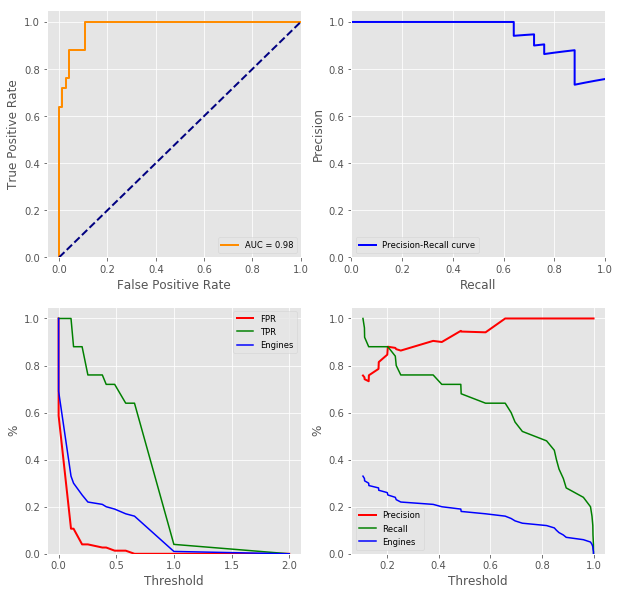

In [187]:
display(gs_clf_RF_A, gs_clf_RF_B)
metrics_clf_RF_A, roc_RF_A, prc_RF_A = bin_class_metrics(model_A, y_test, pred_clf_RF_A.y_pred, pred_clf_RF_A.y_score, print_out=False, plot_out=True)
metrics_clf_RF_B, roc_RF_B, prc_RF_B = bin_class_metrics(model_B, y_test, pred_clf_RF_B.y_pred, pred_clf_RF_B.y_score, print_out=False, plot_out=False)

### SVM

In [188]:
gs_params = {'C': [0.01,0.1,1.0]}
gs_score = 'roc_auc'


model_A = 'SVM A'
clf_svc_A = SVC(kernel='rbf', random_state=123)
model_B = 'SVM B'
clf_svc_B = SVC(kernel='rbf', random_state=123)

gs_clf_svc_A, pred_clf_svc_A = grid_search_classifier(model_A, clf_svc_A, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
gs_clf_svc_B, pred_clf_svc_B = grid_search_classifier(model_B, clf_svc_B, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score)

eval_svc_A = evaluate_classifier(model_A, gs_clf_svc_A, X_test, y_test)
eval_svc_B = evaluate_classifier(model_B, gs_clf_svc_B, X_test_fx, y_test)

metrics_svc = pd.concat([eval_svc_A, eval_svc_B], axis=1)
display(metrics_svc)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,SVM A,SVM B
Accuracy,0.810000,0.910000
Balanced Accuracy,0.620000,0.833333
Precision,1.000000,0.944444
Recall,0.240000,0.680000
F1 Score,0.387097,0.790698
ROC AUC,0.943467,0.906667


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=123,
    shrinking=True, tol=0.001, verbose=False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=123,
    shrinking=True, tol=0.001, verbose=False)

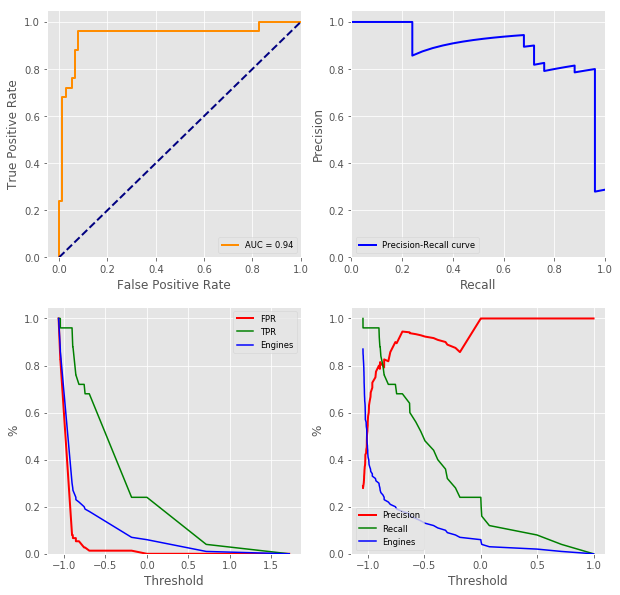

In [189]:
display(gs_clf_svc_A, gs_clf_svc_B)
metrics_clf_svc_A, roc_svc_A, prc_svc_A = bin_class_metrics(model_A, y_test, pred_clf_svc_A.y_pred, pred_clf_svc_A.y_score, print_out=False, plot_out=True)
metrics_clf_svc_B, roc_svc_B, prc_svc_B = bin_class_metrics(model_B, y_test, pred_clf_svc_B.y_pred, pred_clf_svc_B.y_score, print_out=False, plot_out=False)

### Compare All Binary Classifications

In [190]:
metrics_bn = pd.concat([metrics_lr, metrics_LSVC, metrics_svc,  metrics_gnb, metrics_KNN, metrics_RF], axis=1)
display(metrics_bn)

,Logistic Regression A,Logistic Regression B,Linear SVC A,Linear SVC B,SVM A,SVM B,Gaussian NB A,Gaussian NB B,KNN A,KNN B,Random Forest Classifier A,Random Forest Classifier B
Accuracy,0.910000,0.920000,0.880000,0.940000,0.810000,0.910000,0.940000,0.940000,0.910000,0.920000,0.900000,0.910000
Balanced Accuracy,0.820000,0.853333,0.773333,0.933333,0.620000,0.833333,0.933333,0.946667,0.833333,0.853333,0.813333,0.833333
Precision,1.000000,0.947368,0.933333,0.851852,1.000000,0.944444,0.851852,0.827586,0.944444,0.947368,0.941176,0.944444
Recall,0.640000,0.720000,0.560000,0.920000,0.240000,0.680000,0.920000,0.960000,0.680000,0.720000,0.640000,0.680000
F1 Score,0.780488,0.818182,0.700000,0.884615,0.387097,0.790698,0.884615,0.888889,0.790698,0.818182,0.761905,0.790698
ROC AUC,0.980267,0.979200,0.972800,0.977600,0.943467,0.906667,0.987733,0.982133,0.935200,0.962400,0.980267,0.983467


In [191]:
#Let's compare ROC_AUC
metrics_bn.loc['ROC AUC', :].sort_values()

SVM B                         0.906667
KNN A                         0.935200
SVM A                         0.943467
KNN B                         0.962400
Linear SVC A                  0.972800
Linear SVC B                  0.977600
Logistic Regression B         0.979200
Random Forest Classifier A    0.980267
Logistic Regression A         0.980267
Gaussian NB B                 0.982133
Random Forest Classifier B    0.983467
Gaussian NB A                 0.987733
Name: ROC AUC, dtype: float64

Text(0.5, 1.0, 'Precision Recall Curve')

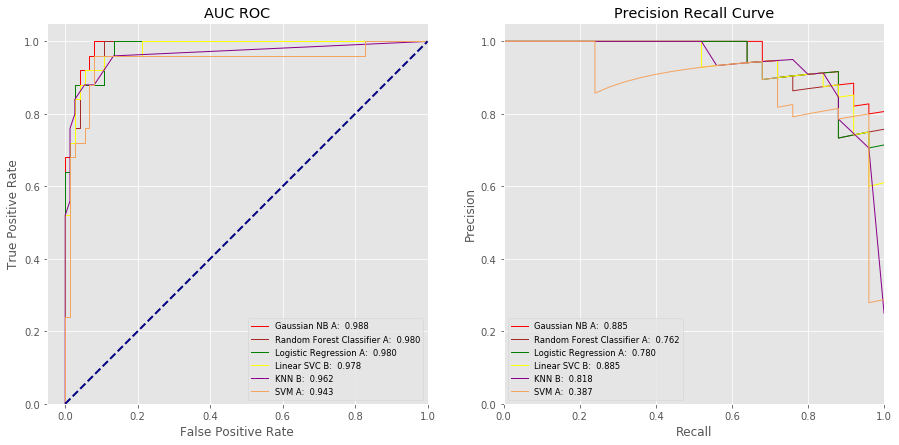

In [192]:
# Lets draw the consolidated ROC Threshold and Precision-Recall Threshold Curves for all the algrorithms
# Plot AUC-ROC and precision-recall curves for best models i.e. GNB_A, RFC_A, LR_A, LSVC_B, KNN_B, SVM_A

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(15,7)

ax1.plot(roc_gnb_A.FPR, roc_gnb_A.TPR, color='red', lw=1, label= metrics_clf_gnb_A.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_gnb_A.at['ROC AUC', metrics_clf_gnb_A.columns.values.tolist()[0]])
ax1.plot(roc_RF_A.FPR, roc_RF_A.TPR, color='brown', lw=1, label= metrics_clf_RF_A.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_RF_A.at['ROC AUC', metrics_clf_RF_A.columns.values.tolist()[0]])
ax1.plot(roc_clf_lr_A.FPR, roc_clf_lr_A.TPR, color='green', lw=1, label= metrics_clf_lr_A.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_lr_A.at['ROC AUC', metrics_clf_lr_A.columns.values.tolist()[0]])
ax1.plot(roc_LSVC_B.FPR, roc_LSVC_B.TPR, color='yellow', lw=1, label= metrics_clf_LSVC_B.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_LSVC_B.at['ROC AUC', metrics_clf_LSVC_B.columns.values.tolist()[0]])
ax1.plot(roc_KNN_B.FPR, roc_KNN_B.TPR, color='darkmagenta', lw=1, label= metrics_clf_KNN_B.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_KNN_B.at['ROC AUC', metrics_clf_KNN_B.columns.values.tolist()[0]])
ax1.plot(roc_svc_A.FPR, roc_svc_A.TPR, color='sandybrown', lw=1, label= metrics_clf_svc_A.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_svc_A.at['ROC AUC', metrics_clf_svc_A.columns.values.tolist()[0]])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('AUC ROC')



ax2.plot(prc_gnb_A.Recall, prc_gnb_A.Precision, color='red', lw=1, label= metrics_clf_gnb_A.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_gnb_A.at['F1 Score', metrics_clf_gnb_A.columns.values.tolist()[0]])
ax2.plot(prc_RF_A.Recall, prc_RF_A.Precision, color='brown', lw=1, label= metrics_clf_RF_A.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_RF_A.at['F1 Score', metrics_clf_RF_A.columns.values.tolist()[0]])
ax2.plot(prc_clf_lr_A.Recall, prc_clf_lr_A.Precision, color='green', lw=1, label= metrics_clf_lr_A.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_lr_A.at['F1 Score', metrics_clf_lr_A.columns.values.tolist()[0]])
ax2.plot(prc_LSVC_B.Recall, prc_LSVC_B.Precision, color='yellow', lw=1, label= metrics_clf_LSVC_B.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_LSVC_B.at['F1 Score', metrics_clf_LSVC_B.columns.values.tolist()[0]])
ax2.plot(prc_KNN_B.Recall, prc_KNN_B.Precision, color='darkmagenta', lw=1, label= metrics_clf_KNN_B.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_KNN_B.at['F1 Score', metrics_clf_KNN_B.columns.values.tolist()[0]])
ax2.plot(prc_svc_A.Recall, prc_svc_A.Precision, color='sandybrown', lw=1, label= metrics_clf_svc_A.columns.values.tolist()[0] + ':  %.3f' % metrics_clf_svc_A.at['F1 Score', metrics_clf_svc_A.columns.values.tolist()[0]])


ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('Precision Recall Curve')

### BINARY CLASSIFICATION ALGORITHMS - SUMMARY

* With respect to ROC AUC evaluation which basically measures 
> * Same Performance: Random Forest Classifier and Naive Bayes
> * Better Performance: Linear SVC, KNN, 
> * Performance Degraded:Logistics Regression, SVM, 

* With respect to Recalls (which also consider's the False Negative measurements in performance evaluation)
> * All the models have performed better after including additional features in modelling
> * Linear SVC and Naive Bayes have performed better than other models in the harness

* With respect to F1 Score which is the harmonic mean of Precision and Recall 
> * All of the models have performed better after including additional features
> * Linear SVC and GNB have performed better than all other classifiers



So this raises a question which model to select to predict whether or not a turbine will fail or not, in our scenario in next 30 cycles 


**Based on the ROC AUC and Precision Recall curve - Gaussian Naive Bayes has performed best in this situation**

For this we need to perform the COST BENEFIT analysis by comparing:
* the benefits of correct predictions
* vs the penalties of wrong perdiction (i.e. predicting that machine will fail and thus incuring maintenance cost and lost production opportunity)

Such a cost benefit matric are usually designed by Business Domain Experts / Maintenance Experts. Intuitively speaking it will have weigts associated with True Positives, True Negative, False Positives as well as False Negatives and should also consider the contrained operational and maintenance thresholds (we will not go into details of the threshold values in this notebook, but will rather focus on modeling cost benefit matrix assuming some threshold values)

Let's discuss this aspect in details in the next section

### EXPECTED BENEFIT CALCULATION

Let's assume the following numbers:
* True Positive (TP) has benefit of EUR 300 K: the engine's that needs maintenance have been correctly selected by the model
* True Negative (TN) has benefit of EUR 50 K: the engine's that are OK and not selected by model, thus ensuring that we are not doing early maintenance

* False Positive (FP) has cost of EUR -100K: engines that are OK but have been predicted to fail by model, this incuring maintenance cost and loss in productino time
* False Negative (FN) has cost of EUR  -200K: engines that need maintenance but not selected by model, this will mean that we will have do some urgent maintenance activities which will cost more than the planned maintenance

In [193]:
#Let's look at the distribution of test data
print(y_test.value_counts())

0    75
1    25
Name: label_bnc, dtype: int64


No of class instances with Positive Prediction (i.e. MAINTENANCE REQUIRED) = 25

No of class instances with Negative Prediction (i.e NO MAINTENANCE REQUIRED) = 75

We will now calculate the ROC threshold values for all the classifiers. Once that is done we will calculate the maximum possible profit across the models to select which model to pick


In [196]:
TPB = 300
TNB = 50
FPC = -100
FNC = -200

probability_positive = 0.25
probability_negative = 0.75

df_max_profit = pd.DataFrame()

roc_df = [roc_clf_lr_A, roc_clf_lr_B, roc_LSVC_A, roc_LSVC_B, roc_gnb_A, roc_gnb_B, roc_KNN_A, roc_KNN_B, roc_RF_A, roc_RF_A, roc_svc_A, roc_svc_B]

for df in roc_df:
  df['Profit'] = probability_positive*(df.TPR*TPB + df.FNR*FNC) + probability_negative*(df.TNR*TNB + df.FPR*FPC)
  df_max = df[df.Profit == df.Profit.max()]
  df_max_profit = pd.concat([df_max_profit, df_max], ignore_index=True)
  
col_names = ['Profit', 'Model', 'Que', 'Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR', 'FNR']

#Sort results by Profit
df_max_profit = df_max_profit[col_names].sort_values(by='Profit', ascending=False).reset_index(drop=True)
display(df_max_profit)

,Profit,Model,Que,Threshold,TP,FP,TN,FN,TPR,FPR,TNR,FNR
0,53.500000,Gaussian NB A,0.31,0.039856,25,0,69,6,1.00,0.080000,0.920000,1.000000
1,52.704225,Gaussian NB B,0.29,0.791340,24,1,70,5,0.96,0.066667,0.933333,0.985915
2,52.473684,Logistic Regression A,0.24,0.211685,22,3,73,2,0.88,0.026667,0.973333,0.960526
3,51.869863,Linear SVC B,0.27,0.036588,23,2,71,4,0.92,0.053333,0.946667,0.972603
4,51.214286,SVM A,0.30,-0.901244,24,1,69,6,0.96,0.080000,0.920000,0.985714
5,51.000000,Logistic Regression B,0.25,0.117968,22,3,72,3,0.88,0.040000,0.960000,0.960000
6,51.000000,Random Forest Classifier A,0.25,0.203848,22,3,72,3,0.88,0.040000,0.960000,0.960000
7,51.000000,Random Forest Classifier A,0.25,0.203848,22,3,72,3,0.88,0.040000,0.960000,0.960000
8,50.097403,KNN B,0.23,0.307692,21,4,73,2,0.84,0.026667,0.973333,0.948052
9,50.097403,SVM B,0.23,-0.540192,21,4,73,2,0.84,0.026667,0.973333,0.948052


Gaussian Naive Bayes has the best profit per engine (EUR 52 ~ 53 K) if the company has the capacity to maintain 31% of the engines per period (Queue)

For scenario where there are maintenance operational contraints - the same method can be applied

In [198]:
df_max_profit = df_max_profit[col_names].sort_values(by=['Que','Profit'], ascending=[True, False]).reset_index(drop=True)
display(df_max_profit)

,Profit,Model,Que,Threshold,TP,FP,TN,FN,TPR,FPR,TNR,FNR
0,50.097403,KNN B,0.23,0.307692,21,4,73,2,0.84,0.026667,0.973333,0.948052
1,50.097403,SVM B,0.23,-0.540192,21,4,73,2,0.84,0.026667,0.973333,0.948052
2,46.246753,KNN A,0.23,0.384615,20,5,72,3,0.80,0.040000,0.960000,0.935065
3,52.473684,Logistic Regression A,0.24,0.211685,22,3,73,2,0.88,0.026667,0.973333,0.960526
4,51.000000,Logistic Regression B,0.25,0.117968,22,3,72,3,0.88,0.040000,0.960000,0.960000
5,51.000000,Random Forest Classifier A,0.25,0.203848,22,3,72,3,0.88,0.040000,0.960000,0.960000
6,51.000000,Random Forest Classifier A,0.25,0.203848,22,3,72,3,0.88,0.040000,0.960000,0.960000
7,49.527027,Linear SVC A,0.26,-0.314730,22,3,71,4,0.88,0.053333,0.946667,0.959459
8,51.869863,Linear SVC B,0.27,0.036588,23,2,71,4,0.92,0.053333,0.946667,0.972603
9,52.704225,Gaussian NB B,0.29,0.791340,24,1,70,5,0.96,0.066667,0.933333,0.985915


For constrained operations:
* Working at capacity of 25% Random Forest Classifier gives Best Profit of 51K EUR per engine
* Working at capcity of 27% -> Linear SVC gives Best Profit of 51.8K EUR per engine

#**Summary**
With the use of Expected Benefit Value method to calculate business gain in monetary units - we can compare different classification methods and support decision making in different operating conditions


https://www.amazon.com/Data-Science-Business-Data-Analytic-Thinking/dp/1449361323